# Intro

In this approach, I combine the ideas of two cnn models: 1- inception module in googlenet 2- Resnet structure. In this approach I used 3x3 convolutional layers to extract features from original image. Because of power of convolutional layers to tackle overfitting, I didn't use drop out in this layers. Instead, I use spatial dropout layer, which tries to remove dependencies between filters of convolutional layers. In the first steps of network, I think it is critical.<br>
After that I added these extracted features to modifications of original image. The resulted features map are then feeded to another conv layer to extract final layers. The rest of the network is identical to classification common networks (flatten, dense and softmax layers).<br>
The full structure of network can be seen below.<br>

<img src="https://raw.githubusercontent.com/amirfallah1988/Fashion-MNIST/master/first_approach.png" title= "network structre"/> <br>

**Why choosing this structure** <br>
I chose this structure because after considering the training data, I realized that we have to use original image beside the features which we extracted. So I extracted features and add this to original image. With this process, I tried to emphasis on important features of each image(for example emphasis on heels in boot class or Sleeves in shirt class).<br>

**Notes** <br>
- I followed two main target in designing this network: 1- accuracy 2- complexity. I wanted to acheive both of them, i.e. design a simple and conceptual model with acceptable performance.
- I tried to design a simple model with minimum parameters which also has good performance.<br>
- For get more generality, I use data augmentation techniques which the details can be found in following cells.<br>
- I used learning rate decay to improve the performance when the loss function get stock in plateaus.<br>


## Importing modules

In [130]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import time

## Paramter setting

In [204]:
batch_size     = 64
nb_classes     = 10
nb_ephochs     = 100

## Load and prepare data
Here the fashion mnist dataset is loaded. The shape of dataset is proper (28x28), but for process with keras, need some modifications:<br>
**1-** The values of pixels are in range of 0-255. So it must normalize. For normalization I just divide each value by 255.<br>
**2-** The dimension of data must expand to 3.<br>
**3-** For use the data for classification task, I convert data's label to categorical form. <br>
**4-** Before divide -just for assurance- I shuffle the data.

In [205]:
# Load data
(All_data, All_labels), (x_test, y_test) = fashion_mnist.load_data()

# preprocess data

All_data=All_data/255
All_data=np.expand_dims(All_data, axis=3)
input_shape= (All_data.shape[1],All_data.shape[2],1)

All_labels_categorical=utils.to_categorical(All_labels, num_classes=nb_classes)

# shuffle data
p=np.random.permutation(len(All_data))
All_data=All_data[p]
All_labels_categorical=All_labels_categorical[p]


# prepare test data for further tests
x_test=x_test/255
x_test=np.expand_dims(x_test, axis=3)  
y_test_categorical=utils.to_categorical(y_test, num_classes=nb_classes)

## Data Augmentation
To improve the accuracy of model, I use augmentation techinques. The augmentation which I used comprises of these features:<br>

- Horizontal flip <br>
- Height shift <br>
- Width shift <br>

In [206]:
Datagen=ImageDataGenerator(horizontal_flip=True,
                                   fill_mode='constant',
                                    width_shift_range=0.1,
                                        height_shift_range=0.1)

## Network structure
In the next cell, the structure of model is defined.

In [210]:
x=layers.Input(shape=input_shape)


n_3x3=layers.Conv2D(32,kernel_size=3,padding='same',activation='relu')(x)
#n_3x3=layers.BatchNormalization()(n_3x3)
n_3x3=layers.SpatialDropout2D(.1)(n_3x3)
#n_3x3=layers.MaxPooling2D(2,padding='same')(n_3x3)
#n_3x3=layers.Conv2D(32,kernel_size=3,padding='same',activation='relu')(n_3x3)
#n_3x3=layers.BatchNormalization()(n_3x3)
#n_3x3=layers.MaxPooling2D(2,padding='same')(n_3x3)
#n_3x3=layers.Conv2D(8,kernel_size=3,padding='same',activation='relu')(n_3x3)
#n_3x3=layers.BatchNormalization()(n_3x3)

aux_input=layers.Conv2D(32,kernel_size=1,padding='same',activation='relu')(x)

#aux_input=layers.MaxPooling2D(2,padding='same')(aux_input)

output=layers.Add()([n_3x3,aux_input])
output=layers.BatchNormalization()(output)

output=layers.Conv2D(32,kernel_size=3,padding='valid',activation='relu')(output)
output=layers.MaxPooling2D(4,padding='same')(output)

#output=layers.BatchNormalization()(output)
output=layers.Flatten()(output)
output=layers.Dense(120,activation='relu')(output)
output=layers.Dropout(.4)(output)
output=layers.Dense(30,activation='relu')(output)
output=layers.Dense(10,activation='softmax')(output)

model=Model(x,output)

model.summary()

Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_132 (Conv2D)             (None, 28, 28, 32)   320         input_31[0][0]                   
__________________________________________________________________________________________________
spatial_dropout2d_42 (SpatialDr (None, 28, 28, 32)   0           conv2d_132[0][0]                 
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 28, 28, 32)   64          input_31[0][0]                   
___________________________________________________________________________________________

## Optimizer, loss and metric
Based on my own experience and also after test SGD optimzers, I choosed ADAM optimzer with learning rate equal to 0.001.<br>
I also tested both MSE and categorical crossentropy as loss function and as I expected the categorical cross entropy was the better choice.<br>
For metric, I choose accuracy, just to find out number of correct prediction.

In [212]:
optimizer=optimizers.Adam(learning_rate=0.001)
loss=losses.CategoricalCrossentropy()
metric=metrics.Accuracy()

## Callbacks
I use two callbacks to handle the procedure of learning: <br>
**1-** Checkpoint model: to save the best model in learning procedure. <br>
**2-** Reduce learning rate in plateau: to decay the learning rate when the loss value get stuck in plateau. <br>

In [213]:
mc=callbacks.ModelCheckpoint('first_approach_model.hdf5',save_best_only=True)
rop=callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=4 , min_delta=0.01,verbose=1)

## Train the model
**Note** <br>
**_- Cross validation techniques can be used in evaluating the performance of the model, but to hold the process succinct I didn't use it._** <br>
**- The data was splited to train and validation for evaluate the performance.**

In [214]:
# split data to train and validation
x_train,x_val,y_train_categorical,y_val_categorical=train_test_split(All_data,All_labels_categorical,test_size=.1)


# compile

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train
start_time=time.time()
h=model.fit_generator(Datagen.flow(x_train, y_train_categorical, batch_size=batch_size),
            steps_per_epoch=round(len(x_train) / batch_size),
            epochs = nb_ephochs,
                validation_data=(x_val, y_val_categorical),
            # validation_split=.15 ,
            callbacks=[mc,rop],verbose=1
            )
train_time=time.time()-start_time



   

Epoch 1/100
759/759 [==============================] - 198s 261ms/step - loss: 0.8377 - accuracy: 0.6842 - val_loss: 0.4673 - val_accuracy: 0.8163
Epoch 2/100
759/759 [==============================] - 190s 250ms/step - loss: 0.5903 - accuracy: 0.7776 - val_loss: 0.4073 - val_accuracy: 0.8476
Epoch 3/100
759/759 [==============================] - 192s 252ms/step - loss: 0.5260 - accuracy: 0.8044 - val_loss: 0.3604 - val_accuracy: 0.8659
Epoch 4/100
759/759 [==============================] - 193s 254ms/step - loss: 0.4861 - accuracy: 0.8199 - val_loss: 0.3279 - val_accuracy: 0.8813
Epoch 5/100
759/759 [==============================] - 189s 249ms/step - loss: 0.4587 - accuracy: 0.8318 - val_loss: 0.3261 - val_accuracy: 0.8804
Epoch 6/100
759/759 [==============================] - 203s 268ms/step - loss: 0.4341 - accuracy: 0.8383 - val_loss: 0.3166 - val_accuracy: 0.8843
Epoch 7/100
759/759 [==============================] - 189s 249ms/step - loss: 0.4205 - accuracy: 0.8447 - val_loss: 0

759/759 [==============================] - 212s 280ms/step - loss: 0.2378 - accuracy: 0.9103 - val_loss: 0.2050 - val_accuracy: 0.9241
Epoch 93/100
758/759 [============================>.] - ETA: 0s - loss: 0.2382 - accuracy: 0.9110
Epoch 00093: ReduceLROnPlateau reducing learning rate to 0.00015009464841568844.
759/759 [==============================] - 220s 290ms/step - loss: 0.2382 - accuracy: 0.9110 - val_loss: 0.2087 - val_accuracy: 0.9246
Epoch 94/100
759/759 [==============================] - 212s 280ms/step - loss: 0.2385 - accuracy: 0.9101 - val_loss: 0.2122 - val_accuracy: 0.9222
Epoch 95/100
759/759 [==============================] - 212s 279ms/step - loss: 0.2376 - accuracy: 0.9102 - val_loss: 0.2059 - val_accuracy: 0.9231
Epoch 96/100
759/759 [==============================] - 193s 254ms/step - loss: 0.2397 - accuracy: 0.9115 - val_loss: 0.2087 - val_accuracy: 0.9254
Epoch 97/100
758/759 [============================>.] - ETA: 0s - loss: 0.2393 - accuracy: 0.9120
Epoch 000

## Plotting results of train
The plots below shows the accuracy and loss changes in each epoch, respectively.

([<matplotlib.lines.Line2D at 0x1b8165d7048>],
 Text(0.5, 0, 'epoch'),
 Text(0, 0.5, 'loss'),
 Text(0.5, 1.0, 'Validation Plot'))

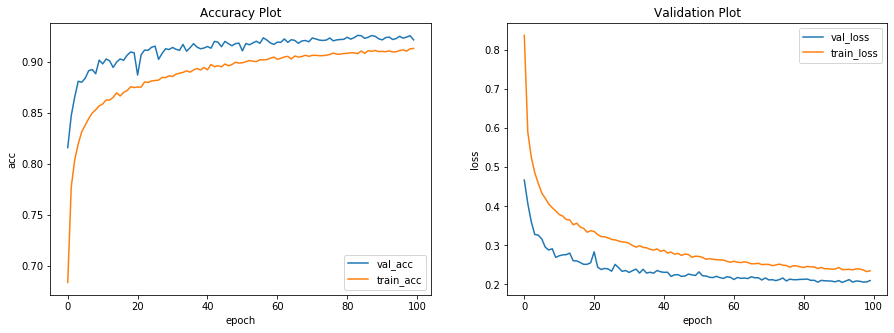

In [215]:
val_acc_logs=model.history.history['val_accuracy']
val_loss_logs=model.history.history['val_loss']


acc_logs=model.history.history['accuracy']
loss_logs=model.history.history['loss']

fig=plt.figure(figsize=(15,5))
fig.add_subplot(1, 2, 1)
plt.plot(val_acc_logs),plt.plot(acc_logs), plt.xlabel('epoch'), plt.ylabel('acc'),plt.legend(['val_acc','train_acc']),plt.title('Accuracy Plot')
fig.add_subplot(1, 2, 2)
plt.plot(val_loss_logs),plt.plot(loss_logs), plt.xlabel('epoch'), plt.ylabel('loss'),plt.legend(['val_loss','train_loss']),plt.title('Validation Plot')


## Time complexity of model
we print here the time of just one fit procedure (not whole kfold procedure). Note that the early stopping can change the time of procedure.<br>
**Note that this time is taken on the cpu, not gpu.**

In [216]:
print ('The estimatd time for train the model:  {}  (seconds)'.format(train_time))

The estimatd time for train the model:  21468.317473888397  (seconds)


## Apply model on test data
Now its time to apply the model on test dataset to see whether the result is promising or not.

In [220]:
result=model.predict(x_test)
result=np.argmax(result,axis=1)
loss_test,acc_test=model.evaluate(x_test,y_test_categorical,verbose=0)
print ('test_accuracy, {:00.3f} '.format(acc_test))
print ('test_loss, {:00.3f}'.format(loss_test))

test_accuracy, 0.915 
test_loss, 0.228


## Confusion Matrix
Here is the confusion matrix of test data to consider the results more precise.

In [218]:
conf_mat=confusion_matrix(y_test, result)
indexes=pd.Index(['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'])
Table=pd.DataFrame(conf_mat,index=indexes,columns=indexes)
Table

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,813,0,12,14,3,1,151,0,6,0
Trouser,1,985,1,9,0,0,2,0,2,0
Pullover,12,0,866,8,43,0,71,0,0,0
Dress,8,4,7,910,39,0,32,0,0,0
Coat,1,0,39,19,891,0,47,0,3,0
Sandal,0,0,0,0,0,980,0,16,0,4
Shirt,71,0,40,26,61,0,797,0,5,0
Sneaker,0,0,0,0,0,4,0,985,0,11
Bag,0,0,0,2,1,1,2,1,993,0
Ankle boot,0,0,0,0,0,10,0,55,1,934


## Conclusion


In [219]:
stat_indexes=pd.Index(['Num_layers','Num_parameters','Total train_time','Accuracy'])
stat_table=pd.DataFrame([],index=stat_indexes)
stat_table.loc['Num_layers','value']=len(model.layers)
stat_table.loc['Num_parameters','value']=model.count_params()
stat_table.loc['Total train_time','value']=round(train_time,2)
stat_table.loc['Accuracy','value']=round(acc_test*100,2)
stat_table

,value
Num_layers,13.00
Num_parameters,201980.00
Total train_time,21468.32
Accuracy,91.54
